# 0. Libraries

For this notebook, I use a wide range of libraries and packages, all of which can be accessed by clicking on this cell

In [33]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import numpy as np
import statistics
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score
from scipy import stats


# 1. Exploring the dataset
## 1.1 dataset breakdown
Here we have a dataset of biomarkers that are collected from blood of people that either (1) had diabetes, (2) had developed diabetes during the study, and (3) were entirely healthy. I'm tasked with finding some biomarkers that can help to highlight incident diabetes specifically. 

First, we will need to load the data and do some quick analysis to see the nature of the data. First we can load in 'test_project_data.csv' and inspect it. 

In [4]:
diabetes_mtb_full_data = pd.read_csv("test_project_data.csv")

Quite the dataset to download. Since the data is made up of folks that were enrolled with diabetes and folks that developed diabetes it would be good to get numbers on their representation in the data. 

It seems that if you are already prevalent then you are coded as 1 and then incident will be 0. 

If someone develops diabetes in the study it codes as prevalent 0 and then incident being 1.

Finally, not being prevalent and not being incident will mean 0 and then 0, indicating a healthy individual.

There is no way to code for 1 and 1, just wouldn't make sense in this case.

In [5]:
obs_with_na_inc_diabetes = diabetes_mtb_full_data["incident_diabetes"].isna().sum()
print("Observations with NaN data: {}".format(obs_with_na_inc_diabetes))

Observations with NaN data: 143


I wanted to make sure the capacity to know who was incident wasn't compromised by a lack of data. I simply took away the observations that had 'NaN'. These samples in the data are essentially useless to our ultimate purpose so best to just excise them from the data.

In [6]:
diabetes_mtb_inc_cleaned = diabetes_mtb_full_data.dropna(subset=['incident_diabetes','prevalent_diabetes','sex','BMI','age','diabetes_followup_time'])

obs_with_na_inc_diabetes = diabetes_mtb_inc_cleaned["incident_diabetes"].isna().sum()
print("Observations with NaN data: {}".format(obs_with_na_inc_diabetes))

Observations with NaN data: 0


## 1.1.1 'status' variable 

Something that will help make life easier later on is the encoding of the class of observations as 'Incident', 'Prevalent', and 'Healthy' in a variable called 'status'. Based on the rules we defined earlier, we can create the new column by looping through each row and returning the appropriate class. 

In [7]:
# creating a new column based on different column rules 

def classify(row):
    if (row["prevalent_diabetes"] == 0) & (row["incident_diabetes"] == 1):
        return 'Incident'
    elif (row["prevalent_diabetes"] == 0) & (row["incident_diabetes"] == 0):
        return 'Healthy'
    else:
        return 'Prevalent'

diabetes_mtb_inc_cleaned["status"] =  diabetes_mtb_inc_cleaned.loc[:,["prevalent_diabetes","incident_diabetes"]].apply(classify, axis=1)

C:\Users\noah_\AppData\Local\Temp\ipykernel_13612\4154085760.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes_mtb_inc_cleaned["status"] =  diabetes_mtb_inc_cleaned.loc[:,["prevalent_diabetes","incident_diabetes"]].apply(classify, axis=1)


In [8]:
#### quick test
diabetes_mtb_inc_cleaned[diabetes_mtb_inc_cleaned["status"] == "Incident"]

,subject_id,mtb_0018261,mtb_0018266,mtb_0018325,mtb_0018326,mtb_0018327,mtb_0018351,mtb_0018362,mtb_0018470,mtb_0018509,...,mtb_2129124,mtb_2129210,mtb_2129554,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time,status
8,sbj_0008,6381.261,11864.460,9896.124,5710.429,23579.490,NaN,78010.90,9099.404,NaN,...,NaN,NaN,NaN,32.996551,32.73,male,0.0,1.0,7.88,Incident
18,sbj_0018,7601.317,NaN,5918.784,NaN,3923.366,NaN,18516.41,17609.910,NaN,...,NaN,NaN,NaN,31.328312,61.36,male,0.0,1.0,8.55,Incident
20,sbj_0020,7540.105,4329.825,6862.309,6794.757,7822.389,NaN,61724.64,6967.305,NaN,...,NaN,NaN,NaN,34.069880,56.79,female,0.0,1.0,6.49,Incident
26,sbj_0026,NaN,38482.010,30162.620,60281.120,79190.470,NaN,428960.80,14854.280,31581.65,...,NaN,NaN,NaN,28.360740,49.93,male,0.0,1.0,8.17,Incident
39,sbj_0039,NaN,32165.110,15535.210,37637.970,209049.500,NaN,227746.70,17895.120,15806.66,...,NaN,NaN,NaN,29.076581,53.01,male,0.0,1.0,6.46,Incident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8200,sbj_8200,9835.575,36838.090,NaN,NaN,NaN,NaN,70270.02,21128.700,NaN,...,NaN,58269.75,NaN,35.967986,27.73,male,0.0,1.0,5.98,Incident
8207,sbj_8207,9284.600,8347.952,6489.392,NaN,NaN,NaN,77289.27,20377.930,NaN,...,NaN,NaN,NaN,23.508560,32.75,male,0.0,1.0,13.88,Incident
8248,sbj_8248,9582.103,NaN,20974.270,NaN,NaN,NaN,64813.01,18429.960,NaN,...,39950.86,35413.29,NaN,30.820480,44.38,male,0.0,1.0,5.52,Incident
8271,sbj_8271,10214.810,25039.860,13795.220,NaN,NaN,NaN,91569.59,133939.900,NaN,...,NaN,NaN,NaN,37.722910,61.76,female,0.0,1.0,3.23,Incident


## 1.2 demographic breakdowns of the classes of observations
Next, it would be good to have an idea of the covariates and how they might impact the data. Let's go one by one. 

### 1.2.1 Sex 

<Axes: xlabel='status', ylabel='count'>

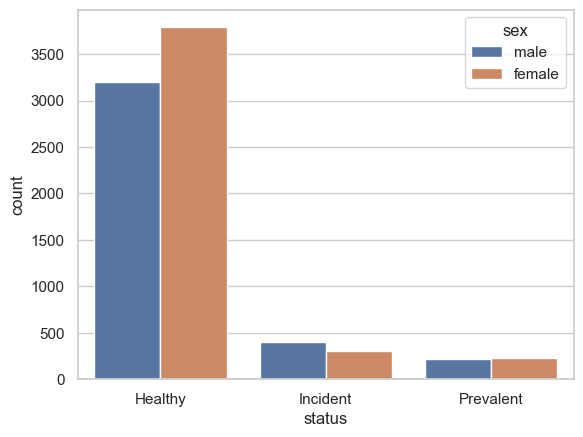

In [9]:
sns.set(style='whitegrid')
 
sns.countplot(x="status",
                hue="sex",
                data=diabetes_mtb_inc_cleaned)

Already, we can see that there is an imbalance in the dataset. Healthy has way more observations comparatively to Incident and Prevalent

### 1.2.2 BMI 

<Axes: xlabel='status', ylabel='BMI'>

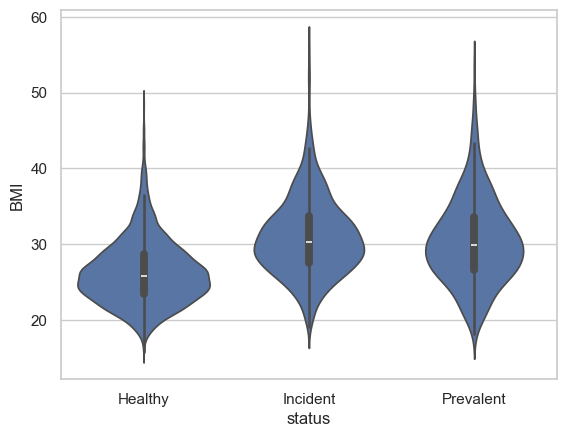

In [10]:
sns.set(style='whitegrid')
 
sns.violinplot(x="status",
                y="BMI",
                data=diabetes_mtb_inc_cleaned)

### 1.2.3 Age 

<Axes: xlabel='status', ylabel='age'>

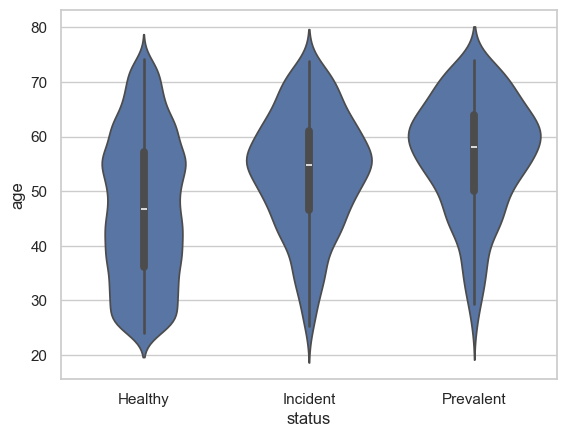

In [11]:
sns.set(style='whitegrid')
 
sns.violinplot(x="status",
                y="age",
                data=diabetes_mtb_inc_cleaned)

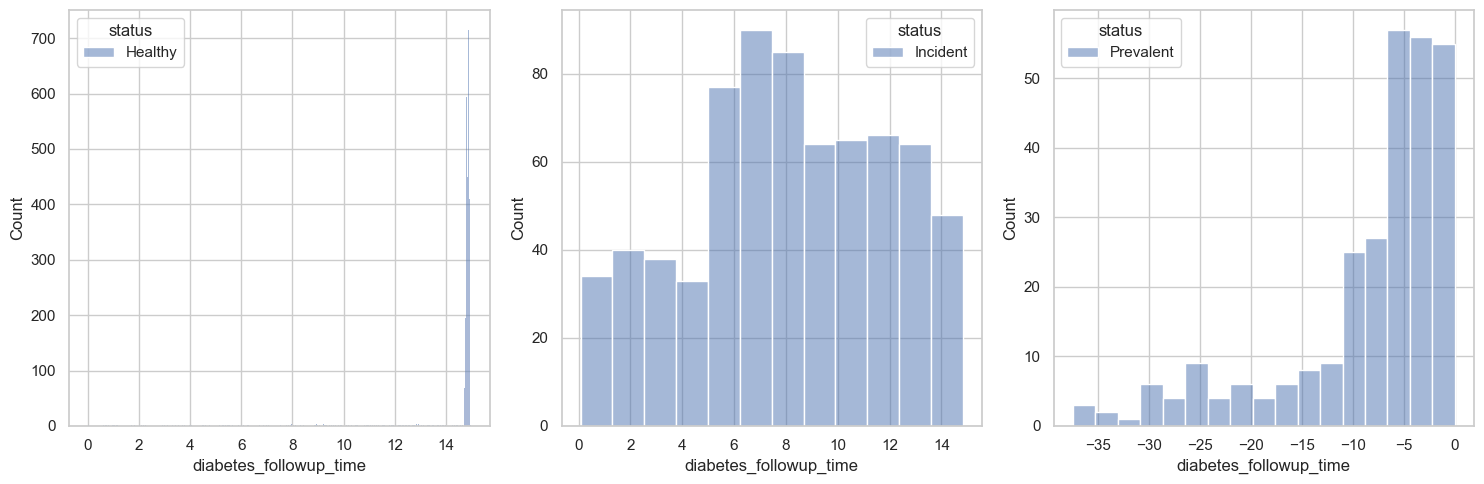

In [15]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
 
sns.histplot(hue="status",
                x="diabetes_followup_time",
                data=diabetes_mtb_inc_cleaned[diabetes_mtb_inc_cleaned['status']=="Healthy"],
                ax=axes[0])


sns.histplot(hue="status",
                x="diabetes_followup_time",
                data=diabetes_mtb_inc_cleaned[diabetes_mtb_inc_cleaned['status']=="Incident"],
                ax=axes[1])


sns.histplot(hue="status",
                x="diabetes_followup_time",
                data=diabetes_mtb_inc_cleaned[diabetes_mtb_inc_cleaned['status']=="Prevalent"],
                ax=axes[2])

# Adjust layout
plt.tight_layout()
plt.show()

Nothing too out of the ordinary here as it seems from the plots of the demographic information. Interesting to see a slightly lower BMI for healthy observations, which makes intuitive sense since folks that develop diabetes probably have a higher body mass. 

## 1.3 Data imputation

Before delving into analyzing the data, there was a note mentioned that some of the 'mtb' data might not have a reading. This can be due to the blood biomarker having a value that is below the level of detection. Once it is below the level of detection, there is now way of knowing the variabilitu int the concentration of the biomarker in the blood. I pondered how to salvage some of this data since NaNs would be not the best to have when doing downstream analyses. 

### 1.3.1 Which biomarkers have the lowest detection levels
I wanted to know how pervasive the LOD/censored data was for each putative biomarker. I looped through the columns, focusing only on the biomarkers and calculated how much of the data was censored. 

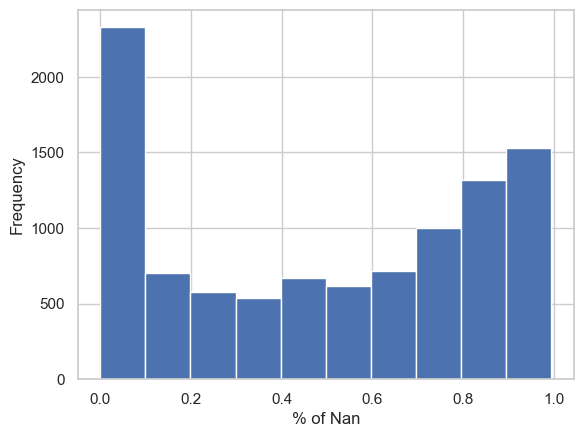

In [23]:
proportions = []
masked_data = []

for series_name, series in diabetes_mtb_inc_cleaned.items():
    if series_name[0:3] == "mtb":
        proportion_nan = series.isna().sum()/len(series)
        if proportion_nan > 0.25:
            masked_data.append(series_name)
        proportions.append(proportion_nan)

diabetes_mtb_inc_cleaned = diabetes_mtb_inc_cleaned.drop(columns=masked_data)
plt.hist(proportions)
plt.xlabel('% of Nan')
plt.ylabel('Frequency')
plt.show()


Even though there are many columns that have NaN values, I will keep the biomarkers that have at least 75% of their data accounted for. I think it will save time when performing feature selection in the later parts of the notebook. 

# 2. Normalizing and Imputing Data
So the mtb data seem to have a large variance in data just by the sight of it. one biomarker might have adrastically different variance than the others it will be almagated with in downstream applications, so it would behoove us to perform some feature scaling so that thedata all falls in a consistent range. 

We have a few options at our disposal, but I decided to use min-max feature scaling since NaN values will be turned into '0.0' after the transformation. I looped through all the biomarker in the dataset and replaced all Nan values in a biomarker with the lowest recorded value in that column. Then we apply the scaler to the column and update the dataframe. 


In [24]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

mtb_columns = []
for column in diabetes_mtb_inc_cleaned.columns: 
    if column[0:3] == "mtb": 
        mtb_columns.append(column)

df_min_max_scaled = diabetes_mtb_inc_cleaned.loc[:,:]

for col in mtb_columns:
    df_min_max_scaled[col] = df_min_max_scaled[col].fillna(df_min_max_scaled[col].min())
    df_min_max_scaled[col] = scaler.fit_transform(df_min_max_scaled[[col]])



# 3. Which blood biomarkers are associated with incident diabetes?

## 3.1 Undersampling the data
My first question is simply to find the blood biomarkers that possess some type of effect on the development of incidnet diabetes. I can't answer the question easily if there is a large imbalance in the data, like what we currently have at the moment. To deal with this, I plan to resample from the dataset in a way where all the classes are equally represented. That means splitting up the data by Healthy, Incident, and Prevalent observations. Since Healthy is the clearly larger of the classes, I will undersample from that group. 

<Axes: xlabel='status', ylabel='count'>

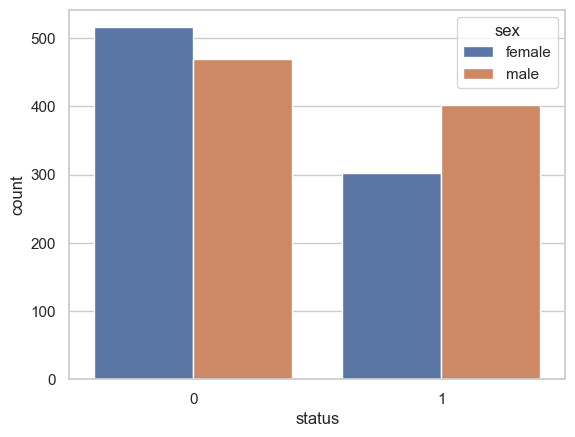

In [43]:
# status_map goes 0,1,2 because I want to discriminate between the 3 classes to do appropriate resampling 
status_map = {"Healthy": 0, "Incident": 1, "Prevalent":2}
df_diabetes_vs_healthy = df_min_max_scaled.loc[:,:]

df_diabetes_vs_healthy["status"] = df_min_max_scaled["status"].map(status_map)
df_diabetes_vs_healthy["status"]

df_majority = df_diabetes_vs_healthy[(df_diabetes_vs_healthy["status"]==0)] 
df_minority = df_diabetes_vs_healthy[(df_diabetes_vs_healthy["status"]==1)] 
df_minority_prev = df_diabetes_vs_healthy[(df_diabetes_vs_healthy["status"]==2)] 

df_majority_undersampled = resample(df_majority,replace=False,n_samples= len(df_minority["status"]), random_state=1234)  
df_sampled = pd.concat([df_majority_undersampled, df_minority,df_minority_prev])
df_sampled['status'] = [0 if x == 2 else x for x in df_sampled["status"]]

sns.set(style='whitegrid')
 
sns.countplot(x="status",
                hue="sex",
                data=df_sampled)


## 3.2 ANOVA 
My first initial take on finding the biomarkers that can classify Incident diabetes is to run an ANOVA test on each biomarker with covariates included and report the biomarkers with low p.values at the significance level of 0.05. ANOVA will essentially test that for the biomarker of interest, do the means and distributions of the biomarker concentrations differentiate Incident to the Control. 

In [45]:
anova_pval_table= []
print(df_sampled)
i = 0
for column in df_sampled: 
    if column[0:3] == "mtb":
        result = statsmodels.formula.api.ols("status ~ {} + BMI + sex + age + diabetes_followup_time ".format(column), data=df_sampled).fit()
        table = statsmodels.api.stats.anova_lm(result,typ=2)
        row = [column,table.loc[column,"PR(>F)"]]
        anova_pval_table.append(row)
        i += 1
        if i % 100 == 0:
            print("models are {}% done".format((i/len(df_sampled.columns))*100))


     subject_id  mtb_0018261  mtb_0018325  mtb_0018362  mtb_0018536  \
3090   sbj_3090     0.060543     0.122775     0.131176     0.008613   
422    sbj_0422     0.069070     0.042512     0.091951     0.004246   
7484   sbj_7484     0.061359     0.051682     0.114527     0.031796   
7755   sbj_7755     0.045832     0.052647     0.095513     0.007334   
3740   sbj_3740     0.072783     0.028495     0.114419     0.008549   
...         ...          ...          ...          ...          ...   
8184   sbj_8184     0.075415     0.075176     0.114010     0.006901   
8228   sbj_8228     0.076675     0.000000     0.119454     0.008644   
8232   sbj_8232     0.079704     0.102581     0.112813     0.007741   
8256   sbj_8256     0.071861     0.068363     0.114429     0.001852   
8273   sbj_8273     0.087202     0.073328     0.104622     0.043435   

      mtb_0018607  mtb_0018878  mtb_0018885  mtb_0018973  mtb_0018978  ...  \
3090     0.125561     0.140087     0.124488     0.056775     0.073542

I wanted to also pair the p value data with a strength of association test for the biomarker and the target variable. Point Biserial correlation appeared to fulfill the need I had for a metric that compares continuous biomarker data to categorical incidental diabetes data. 

In [ ]:
### Associations 
anova_results_healthy_diabetes = pd.DataFrame(anova_pval_table, columns=['biomarker','anova_pval'])

point_biserial = []
for marker in anova_results_healthy_diabetes["biomarker"]:
    r_pb, p_value = stats.pointbiserialr(df_sampled[marker], df_sampled['status'])
    point_biserial.append(r_pb)

anova_results_healthy_diabetes["point_biserial"] = point_biserial
anova_results_healthy_diabetes.to_csv("anova_results_healthy_diabetes.csv")


## 3.3 Biomarker selection 

Below I'm showing the biomarkers that have a high statistical significance while also exhibiting a strong association to the target variable. 

In [62]:
anova_biomarkers = anova_results_healthy_diabetes[(anova_results_healthy_diabetes['anova_pval'] < 0.05/len(df_sampled.columns)) & ((anova_results_healthy_diabetes['point_biserial'] < -0.2) | (anova_results_healthy_diabetes['point_biserial'] > 0.2) )]
print(anova_biomarkers)

        biomarker    anova_pval  point_biserial
870   mtb_0584743  8.525727e-06        0.203300
872   mtb_0584850  1.229525e-05        0.205170
1045  mtb_0733731  2.839620e-07        0.208740
1621  mtb_1068685  6.410085e-07       -0.209702
1765  mtb_1180322  4.548022e-07       -0.218386
2004  mtb_1311918  7.373038e-08       -0.226053


I am interested in how filtering the biomarkers in general might impact the type of discrimination of the data. I am utilizing Linear Discriminant Analysis as a Supervised method to separate the data based on the biomarkers that seem to have an affect. 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

countor_val = []
for pval in list(np.arange(0.0001,0.1,0.001)):
    for biserial in [0.01,0.05,0.1,0.15,0.2]:

        anova_biomarkers = anova_results_healthy_diabetes[(anova_results_healthy_diabetes['anova_pval'] < pval) & ((anova_results_healthy_diabetes['point_biserial'] < -biserial) | (anova_results_healthy_diabetes['point_biserial'] > biserial) )]

        X = df_sampled[anova_biomarkers["biomarker"]]  # Features
        y = df_sampled['status']  # Target variable (class labels)

        # Step 1: Fit LDA model
        try:
            lda = LinearDiscriminantAnalysis(n_components=1)  # 2 components for 2D plot
            X_lda = lda.fit_transform(X, y)

            # Step 2: Create a DataFrame with LDA components and target variable
            df_lda = pd.DataFrame(X_lda, columns=['LD1'])
            df_lda['target'] = y

            mean_0 = statistics.mean(df_lda[df_lda['target'] == 0]['LD1'])
            mean_1 = statistics.mean(df_lda[df_lda['target'] == 1]['LD1'])

            # Calculate standard deviations
            std_0 = statistics.stdev(df_lda[df_lda['target'] == 0]['LD1'])
            std_1 = statistics.stdev(df_lda[df_lda['target'] == 1]['LD1'])

            # Calculate pooled standard deviation
            pooled_std = ((std_0 ** 2 + std_1 ** 2) / 2) ** 0.5

            # Calculate separability (Cohen's d)
            separability = abs(mean_0 - mean_1) / pooled_std
            #print(f'Separability (Cohen\'s d): {separability}')
            countor_val.append([pval,biserial,separability])
        except:
            continue

slot = pd.DataFrame(countor_val,columns=["pval","biserial","cohen_d"])
print(slot)


In [90]:
slot[slot['cohen_d'] == slot['cohen_d'].max()]

,pval,biserial,cohen_d
2,0.0001,0.1,0.136552


## 3.4 Biomarker's impact 

By testing all the filterings using a double for loop we were able to find the most advantageous pairing. Now I want to visualize the impact

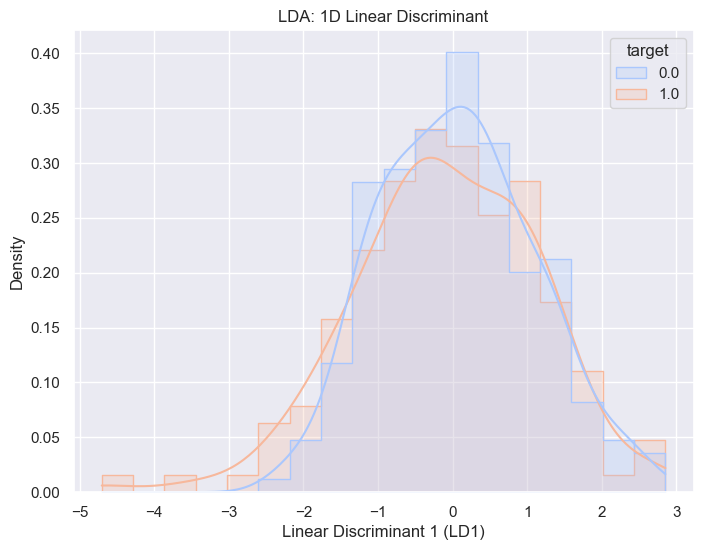

In [91]:
anova_biomarkers = anova_results_healthy_diabetes[(anova_results_healthy_diabetes['anova_pval'] < 0.0001) & ((anova_results_healthy_diabetes['point_biserial'] < -0.1) | (anova_results_healthy_diabetes['point_biserial'] > 0.1) )]
X = df_sampled[anova_biomarkers["biomarker"]] 
y = df_sampled['status']  

lda = LinearDiscriminantAnalysis(n_components=1)  
X_lda = lda.fit_transform(X, y)

df_lda = pd.DataFrame(X_lda, columns=['LD1'])
df_lda['target'] = y

plt.figure(figsize=(8, 6))
sns.histplot(df_lda, x='LD1', hue='target', palette='coolwarm', kde=True, element='step', stat='density', common_norm=False)
plt.title('LDA: 1D Linear Discriminant')
plt.xlabel('Linear Discriminant 1 (LD1)')
plt.grid(True)
plt.show()

Not the most drastic of separations. 

# 4 Alternative approach for biomarker discovery 
## 4.1 Logistic Regression

I wanted to try a different method of calculating p-values, through the use of using a logistic regression model instead of ANOVA to see if the model had an impact

In [96]:
logistic_pval_healthy_vs_diabetes = []
df_sampled['sex'] = [0 if x == 'male' else 1 for x in df_sampled['sex']]

for column in df_sampled.columns: 
    if column[0:3] == "mtb":
        logit_model = statsmodels.api.Logit(df_sampled['status'], df_sampled.loc[:,[column,"BMI","age","diabetes_followup_time",'sex']].astype(float))
        result = logit_model.fit()
        row = [column,result.pvalues.loc[column],result.params.loc[column]]
        logistic_pval_healthy_vs_diabetes.append(row)

     subject_id  mtb_0018261  mtb_0018325  mtb_0018362  mtb_0018536  \
3090   sbj_3090     0.060543     0.122775     0.131176     0.008613   
422    sbj_0422     0.069070     0.042512     0.091951     0.004246   
7484   sbj_7484     0.061359     0.051682     0.114527     0.031796   
7755   sbj_7755     0.045832     0.052647     0.095513     0.007334   
3740   sbj_3740     0.072783     0.028495     0.114419     0.008549   
...         ...          ...          ...          ...          ...   
8184   sbj_8184     0.075415     0.075176     0.114010     0.006901   
8228   sbj_8228     0.076675     0.000000     0.119454     0.008644   
8232   sbj_8232     0.079704     0.102581     0.112813     0.007741   
8256   sbj_8256     0.071861     0.068363     0.114429     0.001852   
8273   sbj_8273     0.087202     0.073328     0.104622     0.043435   

      mtb_0018607  mtb_0018878  mtb_0018885  mtb_0018973  mtb_0018978  ...  \
3090     0.125561     0.140087     0.124488     0.056775     0.073542

In [97]:
logit_results_healthy_diabetes = pd.DataFrame(logistic_pval_healthy_vs_diabetes, columns=['biomarker','logistic_pval','coefficient'])
logit_results_healthy_diabetes.to_csv("logit_results_healthy_diabetes.csv")
logit_results_healthy_diabetes[logit_results_healthy_diabetes['logistic_pval'] < 0.05]

,biomarker,logistic_pval,coefficient
17,mtb_0019529,4.152389e-02,3.212212
79,mtb_0048164,1.809483e-03,40.911434
83,mtb_0049798,4.741646e-02,-3.182437
102,mtb_0057166,4.664711e-02,5.947497
104,mtb_0058300,3.492559e-02,-1.541467
...,...,...,...
3290,mtb_1920057,3.640017e-02,2.838791
3316,mtb_1937469,4.788111e-02,4.432516
3319,mtb_1943069,4.443320e-02,1.821968
3334,mtb_1985184,2.572366e-08,3.629638


## 4.2 Association Tests with the logistic regression
Here I'm recalculating the point biserial correlation

In [98]:
### Associations 
from sklearn.metrics import roc_auc_score
from scipy import stats

point_biserial = []
for marker in logit_results_healthy_diabetes["biomarker"]:
    r_pb, p_value = stats.pointbiserialr(df_sampled.loc[:,marker], df_sampled['status'])
    point_biserial.append(r_pb)


In [99]:
logit_results_healthy_diabetes = pd.DataFrame(logistic_pval_healthy_vs_diabetes, columns=['biomarker','logistic_pval','coefficient'])
logit_results_healthy_diabetes["point_biserial"] = point_biserial
logit_results_healthy_diabetes.to_csv("logit_results_healthy_diabetes.csv")
logit_biomarkers = logit_results_healthy_diabetes[(logit_results_healthy_diabetes['logistic_pval'] < 0.05/10000) & ((logit_results_healthy_diabetes['point_biserial'] < -0.2) | (logit_results_healthy_diabetes['point_biserial'] > .2) )]
logit_liberal_biomarkers = logit_results_healthy_diabetes[logit_results_healthy_diabetes['logistic_pval'] < 0.05]
logit_results_healthy_diabetes[(logit_results_healthy_diabetes['logistic_pval'] < 0.05/10) & ((logit_results_healthy_diabetes['point_biserial'] < -0.05) | (logit_results_healthy_diabetes['point_biserial'] > 0.05) )].to_csv("logit_results_healthy_diabetes.csv")
print(logit_biomarkers)

        biomarker  logistic_pval  coefficient  point_biserial
870   mtb_0584743   2.937041e-06     5.556053        0.203300
1045  mtb_0733731   7.633175e-08     3.238029        0.208740
1621  mtb_1068685   1.488825e-06    -6.442543       -0.209702
1765  mtb_1180322   2.148414e-06    -3.661281       -0.218386
2004  mtb_1311918   6.889152e-08    -7.298915       -0.226053


## 4.3 LDA for the logistic regression biomarkers

In [100]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

countor_val = []
for pval in list(np.arange(0.0001,0.1,0.001)):
    for biserial in [0.01,0.05,0.1,0.15,0.2]:

        logit_biomarkers = logit_results_healthy_diabetes[(logit_results_healthy_diabetes['logistic_pval'] < pval) & ((logit_results_healthy_diabetes['point_biserial'] < -biserial) | (logit_results_healthy_diabetes['point_biserial'] > biserial) )]

        X = df_sampled[logit_biomarkers["biomarker"]]  # Features
        y = df_sampled['status']  # Target variable (class labels)

        # Step 1: Fit LDA model
        try:
            lda = LinearDiscriminantAnalysis(n_components=1)  # 2 components for 2D plot
            X_lda = lda.fit_transform(X, y)

            # Step 2: Create a DataFrame with LDA components and target variable
            df_lda = pd.DataFrame(X_lda, columns=['LD1'])
            df_lda['target'] = y

            mean_0 = statistics.mean(df_lda[df_lda['target'] == 0]['LD1'])
            mean_1 = statistics.mean(df_lda[df_lda['target'] == 1]['LD1'])

            # Calculate standard deviations
            std_0 = statistics.stdev(df_lda[df_lda['target'] == 0]['LD1'])
            std_1 = statistics.stdev(df_lda[df_lda['target'] == 1]['LD1'])

            # Calculate pooled standard deviation
            pooled_std = ((std_0 ** 2 + std_1 ** 2) / 2) ** 0.5

            # Calculate separability (Cohen's d)
            separability = abs(mean_0 - mean_1) / pooled_std
            #print(f'Separability (Cohen\'s d): {separability}')
            countor_val.append([pval,biserial,separability])
        except:
            continue

slot = pd.DataFrame(countor_val,columns=["pval","biserial","cohen_d"])
print(slot)


       pval  biserial   cohen_d
0    0.0001      0.01  0.025925
1    0.0001      0.05  0.035988
2    0.0001      0.10  0.079924
3    0.0001      0.15  0.085427
4    0.0001      0.20  0.012330
..      ...       ...       ...
495  0.0991      0.01  0.020026
496  0.0991      0.05  0.032408
497  0.0991      0.10  0.096373
498  0.0991      0.15  0.086065
499  0.0991      0.20  0.012330

[500 rows x 3 columns]


In [101]:
slot[slot['cohen_d'] == slot['cohen_d'].max()]

,pval,biserial,cohen_d
17,0.0031,0.1,0.103035


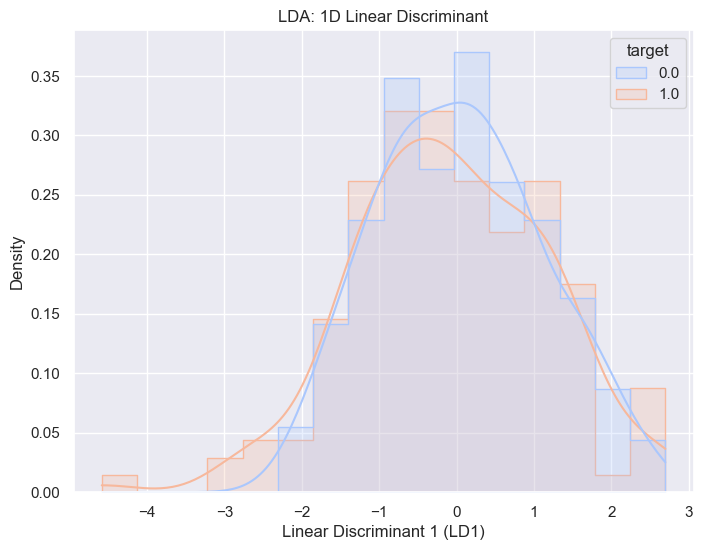

In [102]:
logit_biomarkers = logit_results_healthy_diabetes[(logit_results_healthy_diabetes['logistic_pval'] < 0.0031) & ((logit_results_healthy_diabetes['point_biserial'] < -0.1) | (logit_results_healthy_diabetes['point_biserial'] > 0.1) )]
X = df_sampled[logit_biomarkers["biomarker"]] 
y = df_sampled['status']  

lda = LinearDiscriminantAnalysis(n_components=1)  
X_lda = lda.fit_transform(X, y)

df_lda = pd.DataFrame(X_lda, columns=['LD1'])
df_lda['target'] = y

plt.figure(figsize=(8, 6))
sns.histplot(df_lda, x='LD1', hue='target', palette='coolwarm', kde=True, element='step', stat='density', common_norm=False)
plt.title('LDA: 1D Linear Discriminant')
plt.xlabel('Linear Discriminant 1 (LD1)')
plt.grid(True)
plt.show()

It appears that the biomarkers, while impressive through p-value and association, seem to struggle in separating the data in terms of the Incident Diabetes patients. Printing the biomarkers I found from doing the logistic regression approach and the anova approach.

In [103]:
print(logit_biomarkers)
print(anova_biomarkers)

        biomarker  logistic_pval  coefficient  point_biserial
207   mtb_0104131   8.561571e-05     2.248582        0.120685
328   mtb_0201973   3.017749e-03     1.822736        0.104497
352   mtb_0227994   2.554083e-03     1.494918        0.121201
377   mtb_0248815   1.455472e-03     2.745396        0.153729
420   mtb_0253764   5.274066e-04     2.250574        0.125630
...           ...            ...          ...             ...
2932  mtb_1832482   1.722740e-05     5.510889        0.145364
3050  mtb_1853248   4.507718e-06     2.390859        0.121413
3096  mtb_1858624   2.430729e-05     3.367050        0.120844
3122  mtb_1864139   1.389470e-03     2.278355        0.104685
3334  mtb_1985184   2.572366e-08     3.629638        0.198258

[128 rows x 4 columns]
        biomarker    anova_pval  point_biserial
483   mtb_0324374  2.329450e-06       -0.158845
869   mtb_0584739  2.036080e-05        0.197447
870   mtb_0584743  8.525727e-06        0.203300
872   mtb_0584850  1.229525e-05        0

# 5 Using a prediction model to classify incident diabetes
## 5.1 Random Forest

For the relevant biomarkers, I am using the subset of biomarkers that were discovered in the ANOVA feature selection portion of the notebook. I split my data into training and testing datasets and then proceed to train a Random Forest model to classify Incident observations. 

In [105]:
X = df_sampled.loc[:,anova_biomarkers["biomarker"]]
y = df_sampled.loc[:,"status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

I start off by doing a hyper parameter tuning of the model just to see which set of parameters would demonstrate the best precision as a model.

In [106]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score

# Define the hyperparameter distributions
param_distributions = {
    'n_estimators': [100, 300, 500, 1000],            
    'max_depth': [10, 20, 30, None],                  
    'min_samples_split': [2, 5, 10],                  
    'min_samples_leaf': [1, 2, 4],                    
    'max_features': ['sqrt', 'log2', None],           
    'criterion': ['gini', 'entropy'],                 
    'class_weight': ['balanced', None]                
}

model = RandomForestClassifier(random_state=42)

scorer = make_scorer(precision_score, average='binary') 
random_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_distributions, 
    n_iter=50,           
    scoring=scorer,      
    cv=3,                
    verbose=2,          
    random_state=42
)

# Fit the random search on training data
random_search.fit(X_train, y_train)

# Best model and parameters
print("Best parameters found: ", random_search.best_params_)
print("Best precision score: ", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   5.9s
[CV] END class_weight=balanced, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   5.2s
[CV] END class_weight=balanced, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   5.2s
[CV] END class_weight=None, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END class_weight=None, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END class_weight=None, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators

Here is a Confusion matrix highlighting the ability of the Random Forest model to predict the Incident Diabetes in the dataset.

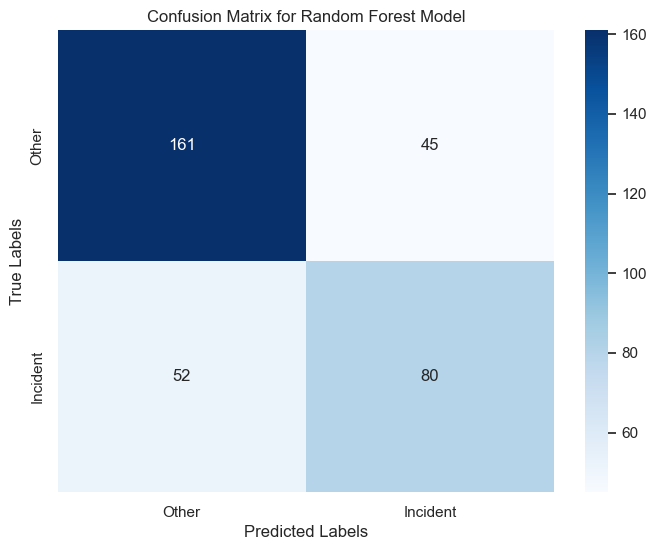

In [116]:
# Train the Random Forest model
model = RandomForestClassifier(
    **random_search.best_params_
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Incident'], yticklabels=['Other', 'Incident'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [115]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Assuming your model is already trained, and predictions are made
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Classification report (Precision, Recall, F1-Score, Support)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Specificity (True Negative Rate)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # Recall is the same as sensitivity

print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity (Recall/TPR): {sensitivity:.2f}")
print(f"Specificity (TNR): {specificity:.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       206
           1       0.65      0.61      0.62       132

    accuracy                           0.72       338
   macro avg       0.70      0.70      0.70       338
weighted avg       0.71      0.72      0.71       338

Confusion Matrix:
[[162  44]
 [ 52  80]]
Accuracy: 0.72
Sensitivity (Recall/TPR): 0.61
Specificity (TNR): 0.79


The model output suggests that the model is doing better than flipping a coin when choosing between Incident diabetes and not. However there is room for improvement, such as increasing both the Type I and II error the model produces from the biomarker features. 